# Project 5 - Intro to Deep Learning Image Classification

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [LearningSuite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below (at the end of this notebook).

<span style="color:red">PLEASE submit only the notebook -- no additional files.</span>

Please also fill in here the time that each part took you:
1. Part A - Dataset: <span style="color:red;">2.5 hrs (includes time for downloading data)</span>
2. Part B - Neural Network Architecture: <span style="color:red;">5 min</span>
3. Part C - Network Training: <span style="color:red;">4 hrs</span>
4. Part D - Testing: <span style="color:red;">1 hr</span>
5. Write-up: <span style="color:red;">20 min</span>

## Background - Image Classification

For this project you will be introduced to the basics of deep learning and the PyTorch framework.  Deep learning can be very computationally expensive and runs fastest with GPU support.  If you do not have access to NVIDIA GPUs on your local machine, you can use some from Google using their [colab tool](https://colab.research.google.com).  Colab runs exactly like jupyter notebooks and you can directly upload your .ipynb file.

Image classification is the task of taking an image and labeling it as a category.  Deep learning has been the leading method for image classification since it dominated the [ImageNet competition in 2012](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf).

# Part A: Dataset

You will be performing classification on the [Stanford Cars Dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html), which consists of 16,185 images of 196 classes of cars.  The dataset is split 50-50 into a training set and testing set.  You will want to download each one idividually from Stanford's site or use these links: [Train Set](http://imagenet.stanford.edu/internal/car196/cars_train.tgz) and [Test Set](http://imagenet.stanford.edu/internal/car196/cars_test.tgz).  Each set is around 1 GB of data so please **<span style="color:red">DO NOT</span>** include the files when you upload your notebook--**just turn in the .ipynb file**.  Assume the notebooks will be run with the images in folders labeled `cars_train` and `cars_test` like so:

```
.
+--proj5-image-classification.ipynb
+--cars_train
|  +--00001.jpg
|  +--00002.jpg
|  +--...
+--cars_test
|  +--00001.jpg
|  +--00002.jpg
|  +--...
+--test_annos.json
+--train_annos.json
```

The first step in any deep learning method is to make sure you can read in the data.  Since there will be a lot of images for this project, it is possible not all of them will fit into memory.  This is a common problem in deep learning and PyTorch has provided a pattern so as to only have the images you need in memory at a time.  They provide a class called `DataLoader` that acts as an iterable object.  To use `DataLoader`, you will need to implement a subclass of PyTorch's `Dataset` class.  To do you so will need to create a class that inherits from `Dataset` and implements the methods `__getitem__` and `__len__`.  An example is given below and PyTorch provides a [tutorial here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html):

```Python
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self):
        super(MyDataset, self).__init__()
#         TODO: implement what happens when someone calls: 
#         dataset = MyDataset()
    
    def __getitem__(self, idx):
#         TODO: implement what happens when someone calls dataset[idx]
#         This typically will return an image and its label 
    
    def __len__(self):
#         TODO: implement what happens when someone calls len(dataset)

dataset = MyDataset()
loader = DataLoader(dataset)
for im, label in loader:
#     TODO: Perform operations
```

We provide you with two files: `test_annos.json` and `train_annos.json`.  These files contain a dictionary mapping image name to the class label the image belongs to.  You can use these files in you Dataset class in order to provide the ground truth labels.  For part A, you will need to implement a dataset class.

**Note:** Both the images and the labels are 1-indexed. You can load the images however you choosed, but the labels must be 0-indexed to work with Pytorch's loss functions. Make sure to account for this in your Dataset class.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import json

from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F

class CarsDataset(Dataset):
    def __init__(self, train=True):
        super(CarsDataset, self).__init__()

        self.folder = 'cars_train' if train else 'cars_test'
        json_file = 'train_annos.json' if train else 'test_annos.json'
        with open(json_file) as f:
            labels_dict = json.load(f)
        self.labels = list(labels_dict.values())

    def __getitem__(self, idx):
#         TODO: implement what happens when someone calls dataset[idx]
#         This typically will return an image and its label

        image_file = str(idx+1).zfill(5)+".jpg"
        image = Image.open(os.path.join(self.folder, image_file))
        if image.mode != 'RGB':
            image = image.convert('RGB')
            
        label = self.labels[idx]-1
        
        image = image.resize((256, 256))
        
        apply_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        image = apply_transforms(image)
        
        return image, label

    def __len__(self):
        return len(self.labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


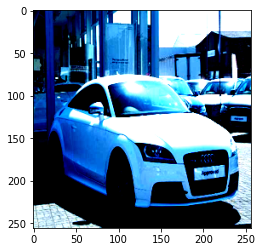

In [3]:
dataset = CarsDataset(train=True)
o = dataset[0][0]
plt.imshow(o.permute(1, 2, 0), vmin=0, vmax=2)
plt.show()

# Part B: Neural Network Architecture

The main backbone for deep learning is the actual neural network architecture.  For image classification, this will consist of some combination of `Conv2d` layers with activations--usually `ReLU`--with intermittent downsampling--usually done using `MaxPool2d`--followed by a few Linear layers.  The input to the network should be an image with shape `(batch_size, channels, image_height, image_width)`(e.g. a single RGB image with dimensions 224x224 would be `(1, 3, 224, 224)`) and the output a vector of shape `(num_classes,)`, where the largest value's index in the output vector indicates the class label.  

While we built our own network in the Learning Lab, for this lab we will used one of Pytorch's pretrained networks. This has the benefit of already having learned features from training on an ImageNet classification problem. To pull in this pretrained network, we use the following line of code:

In [57]:
import torchvision

model = torchvision.models.resnet18(pretrained=True)

print(list(model.__dict__["_modules"].keys()))

['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']


The ResNet18 is a state of the art network that uses convolution layers, batch normalization, layers of residual blocks, and a fully connected layer at the end. The different layers are listed above. However, because the pretrained network was trained on ImageNet, the last layer is designed to predict 1000 classes, not 196 like in our dataset.

In [50]:
print(model.fc)

Linear(in_features=512, out_features=1000, bias=True)


Our goal is to use the same architecture as the ResNet, but replace the last fully connected layer with a new fully connected layer that goes from 512 input features to 196 output features.

PyTorch provides a nice framework for making a neural network architecture.  A network is typically made as a class that inherits from PyTorch's `Module` class and implements the `forward` method.  A network might take the form of the example below. PyTorch also provides a simple Neural Network [tutorial here](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) -- the Training a Classifier tutorial is especially helpful.
```Python
import torch.nn as nn 

class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
#         TODO: setup network here

    def forward(self, x):
#         TODO: perform the forward pass, which happens when someone calls network(x)
```

Take all the pretrained layers from ResNet18, but then define your own last fully connected layer. Then write the appropriate forward pass function.

**Note:** ResNet was trained with images that are normalized according to the ImageNet color averages. This means you may want to include an appropriate normalization in your Dataset class if you did not already. This can easily be done with Pytorch's transform objects.

```Python
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
```

In [58]:
import torch.nn as nn

# no need for a new network class, this line does the job
model.fc = nn.Linear(model.fc.in_features, 196)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
    
model = model.to(device)

Running on the GPU


# Part C: Training

Now that you can access your data and you have a network architecture set up, its time to put things together and start training.  Training requires two additional major components: 1) the loss function and 2) the optimizer.  The loss function is a comparison between your results and the ground truth data.  The optimizer is what takes the results of the loss function and backpropagates the error to the network weights in an attempt to decrease the loss.  The most common loss function used for classification is [Cross Entropy](https://pytorch.org/docs/stable/nn.html#crossentropyloss) while the most commonly used optimizer is [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).  

A basic training step might take the following form:
```Python
optimizer.zero_grad()
outs = model(inputs)
loss = loss_func(outs, labels)  # loss_func would be an instance of a torch.nn.CrossEntropyLoss class
loss.backward()
optimizer.step()  # optimizer would be an instance of the torch.optim.Adam class
```

For deliverables on this section, please display a plot of the value of the loss over time.  If things are working, the loss should be decreasing.

**Note: This step could take several hours so you will want to look into being able to save your model to a file and load it up again.** See [here](https://pytorch.org/docs/stable/notes/serialization.html).

Also, if you are running on Google Colab, your notebook may eventually get disconnected -- Colab limits the amount of time you can spend using their service at one time. You may want to save intermediate results to your Google Drive: see [here](https://medium.com/@ml_kid/how-to-save-our-model-to-google-drive-and-reuse-it-2c1028058cb2).

In [59]:
from tqdm import tqdm
from time import sleep

trainset = CarsDataset(train=True)
testset = CarsDataset(train=False)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # , momentum=0.9)

num_epochs = 10

train_losses = []
train_accs = []
model.train()
for epoch in range(num_epochs):
    print("Epoch:", epoch+1)
    epoch_losses = []
    epoch_accs = []
    sleep(0.5)
    for x, y in tqdm(trainloader):
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        out = model(x)
        loss = loss_func(out, y)
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item()/y.shape[0])
        correct = torch.sum(out.argmax(1) == y).item()
        epoch_accs.append(correct/y.shape[0])
        
    epoch_loss = np.mean(epoch_losses)
    epoch_acc = np.mean(epoch_accs)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    sleep(0.5)
    print(f"Epoch loss: {round(epoch_loss, 4)}  Epoch accuracy: {round(epoch_acc, 4)}\n")
        
torch.save(model.state_dict(), 'cars_net.pt')

Epoch: 1


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [01:51<00:00,  1.75s/it]


Epoch loss: 0.0315  Epoch accuracy: 0.172

Epoch: 2


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [01:58<00:00,  1.85s/it]


Epoch loss: 0.013  Epoch accuracy: 0.6179

Epoch: 3


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [02:04<00:00,  1.95s/it]


Epoch loss: 0.005  Epoch accuracy: 0.8603

Epoch: 4


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [02:06<00:00,  1.98s/it]


Epoch loss: 0.0017  Epoch accuracy: 0.9612

Epoch: 5


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [02:07<00:00,  1.99s/it]


Epoch loss: 0.0006  Epoch accuracy: 0.9904

Epoch: 6


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [02:07<00:00,  2.00s/it]


Epoch loss: 0.0003  Epoch accuracy: 0.9942

Epoch: 7


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [02:07<00:00,  1.99s/it]


Epoch loss: 0.0002  Epoch accuracy: 0.9961

Epoch: 8


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [02:06<00:00,  1.98s/it]


Epoch loss: 0.0001  Epoch accuracy: 0.9977

Epoch: 9


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [02:06<00:00,  1.98s/it]


Epoch loss: 0.0001  Epoch accuracy: 0.9978

Epoch: 10


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [02:07<00:00,  1.99s/it]


Epoch loss: 0.0001  Epoch accuracy: 0.9979



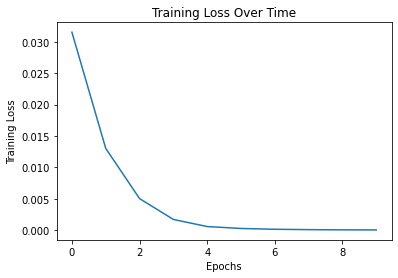

In [60]:
plt.plot(train_losses)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss Over Time")

plt.show()

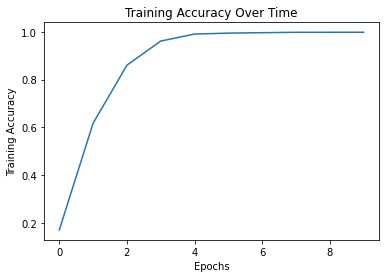

In [61]:
plt.plot(train_accs)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy Over Time")

plt.show()

# Part D: Testing

One of the goals of deep learning is to make a model that generalizes to data it has never seen (e.g. new images of cars).  For this part, you will test your generalizability by running the model on a dataset it has not yet seen during training.  To do so, you will need to make sure you are not calculating any gradients by using `torch.no_grad` in a with statement. You will also need to put the network into evaluation mode:
```Python
model.eval()
with torch.no_grad():
    # enter testing code here
```

To put the network back into training mode, call `model.train()`.

You will also need to compare your actual predictions with the ground truth, value for value.  The output of your network, however, will be a vector of length 196 (the number of possible classes for the cars dataset) with the largest value representing the guessed class.  You will need to extract the predicted class number and compare it with the ground truth class number for all images in the test dataset and calculate the overall accuracy.  **Print out the overall accuacy of your model**.

Additionally, **you will need to generate a confusion matrix of the 196 categories**. A confusion matrix shows how often a specific category is guessed as each other category. For example, the 11th row and 34th column in the matrix should tell you how many times category 11 images were guessed to be category 34 images. Thus, a perfect predictor on the test set would have nonzero values only along the diagnol. Once you generated the confusion matrix, you may simply plot it as a grayscale image (with interpolation turned off).

While high test accuracy is not the only goal in this lab, most students are able to get above 50% in their testing accuracy. If you are unable to reach this level of accuracy, it may indicate an error in your code.

In [62]:
test_losses = []
test_accs = []

confusion_matrix = np.zeros((196, 196))

model.eval()
with torch.no_grad():
    for x, y in tqdm(testloader):
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        out = model(x)
        loss = loss_func(out, y)
        
        test_losses.append(loss.item()/y.shape[0])
        pred = out.argmax(1)  # pred is the whole batch of predictions
        correct = torch.sum(pred == y).item()
        test_accs.append(correct/y.shape[0])
        
        for i in range(len(pred)):
            confusion_matrix[y[i].item()][pred[i].item()] += 1

sleep(0.5)
print("Average test loss:", round(np.mean(test_losses), 4))
print("Average test accuracy:", round(np.mean(test_accs), 4))

100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:40<00:00,  1.25it/s]


Average test loss: 0.0118
Average test accuracy: 0.8036


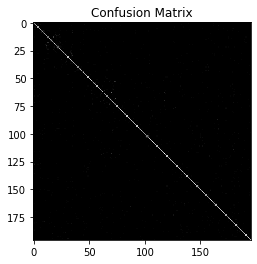

In [63]:
plt.imshow(confusion_matrix, cmap="gray", interpolation="none", vmin=0, vmax=50)
plt.title("Confusion Matrix")

plt.show()

## Grading
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Making a Dataset class
* [10 pts] Setting up you architecture
* [20 pts] Training your model and plotting training loss
* [30 pts] Displaying the overall accuracy of your model and a confusion matrix

The last 20 points are earned through completing a subset of the following explorations:
* [10 pts] Enhance your dataloader to include reflection data augmentation (i.e. double the size of your training data by taking the mirror image across the y-axis). **DO NOT** do reflection augmentation across the x-axis (we don't care to detect cars when they are upside down!). Describe what effects the augmentation had on testing accuracy.
* [10 pts] Enhance your dataloader to include random resized crop data augmentation (i.e. increase the size of your training data by taking a subsection of your image each time). Make sure the crop is not too small, otherwise you might miss parts of the car. Describe what effects the augmentation had on testing accuracy.
* [10 pts] Analyze the effect of learning rates on the accuracy of the network. Describe what you found and give supporting plots.
* [10 pts] Analyze the effect of changing the number of training epochs on the accuracy of the network. Describe what you found and give supporting plots.
* [10 pts] Analyze the effect of varying the batch_size on the accuracy of the network. Describe what you found and give supporting plots. 
* [10 pts] Analyze the effect of different optimizers on the accuracy of the network. Describe what you found and give supporting plots. A list of optimizers in Pytorch can be found [here](https://pytorch.org/docs/stable/optim.html).
* [10 pts] Analyze the effect of different pretrained networks on the accuracy of the network. Describe what you found and give supporting plots. A list of pretrained networks in Pytorch can be found [here](https://pytorch.org/docs/stable/torchvision/models.html).

You may earn up to 10 points extra credit for additional explorations you complete.

An additional 15 points of extra credit will be given to the individual with the highest test accuracy.

In [42]:
def train_and_test(lr=0.001, num_epochs=5, batch_size=64):
    print(f"Training and testing model with:\tlearning_rate={lr}\tnum_epochs={num_epochs}\tbatch_size={batch_size}...")
    
    model = torchvision.models.resnet18(pretrained=True)

    model.fc = nn.Linear(model.fc.in_features, 196)

    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
        print("Running on the CPU!")

    model = model.to(device)

    trainset = CarsDataset(train=True)
    testset = CarsDataset(train=False)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    #################### TRAIN #####################
    train_losses = []
    train_accs = []
    
    model.train()
    sleep(0.5)
    for epoch in tqdm(range(num_epochs)):
        epoch_losses = []
        epoch_accs = []
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = loss_func(out, y)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item()/y.shape[0])
            correct = torch.sum(out.argmax(1) == y).item()
            epoch_accs.append(correct/y.shape[0])
            
        train_losses.append(np.mean(epoch_losses))
        train_accs.append(np.mean(epoch_accs))

    plt.plot(train_losses)
    plt.xlabel("Epochs")
    plt.ylabel("Training Loss")
    plt.title("Training Loss Over Time")
    
    plt.show()

    #################### TEST ######################
    test_losses = []
    test_accs = []

    model.eval()
    print("Testing...")
    sleep(0.5)
    with torch.no_grad():
        for x, y in tqdm(testloader):
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = loss_func(out, y)

            test_losses.append(loss.item()/y.shape[0])
            correct = torch.sum(out.argmax(1) == y).item()
            test_accs.append(correct/y.shape[0])

    sleep(0.5)
    print("Average test loss:", round(np.mean(test_losses), 4))
    print("Average test accuracy:", round(np.mean(test_accs), 4))
    print()
    
    return np.mean(test_losses), np.mean(test_accs)

## Test Different Learning Rates

Training and testing model with:	learning_rate=0.1	num_epochs=5	batch_size=64...


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [09:03<00:00, 108.73s/it]


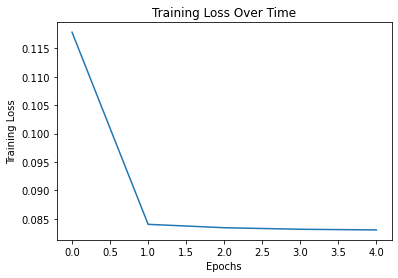

Testing...


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:36<00:00,  1.30it/s]


Average test loss: 0.0812
Average test accuracy: 0.0106

Training and testing model with:	learning_rate=0.01	num_epochs=5	batch_size=64...


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [10:06<00:00, 121.29s/it]


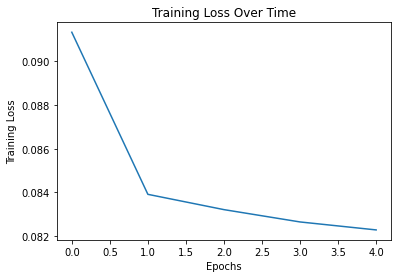

Testing...


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:36<00:00,  1.31it/s]


Average test loss: 0.0817
Average test accuracy: 0.0155

Training and testing model with:	learning_rate=0.001	num_epochs=5	batch_size=64...


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [10:08<00:00, 121.67s/it]


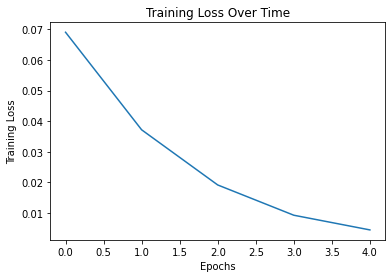

Testing...


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:35<00:00,  1.31it/s]


Average test loss: 0.0285
Average test accuracy: 0.5294

Training and testing model with:	learning_rate=0.0001	num_epochs=5	batch_size=64...


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [10:05<00:00, 121.06s/it]


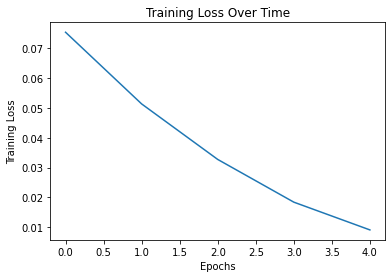

Testing...


100%|██████████████████████████████████████████████████████████████████████████████| 126/126 [1:02:04<00:00, 29.56s/it]


Average test loss: 0.025
Average test accuracy: 0.7359

Training and testing model with:	learning_rate=1e-05	num_epochs=5	batch_size=64...


100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [3:16:04<00:00, 2352.90s/it]


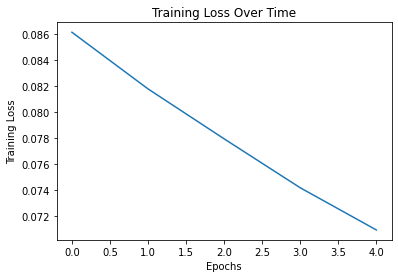

Testing...


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:37<00:00,  1.29it/s]


Average test loss: 0.0723
Average test accuracy: 0.1216



In [43]:
# Test different learning rates
lrs_list = [0.1, 0.01, 0.001, 0.0001, 0.00001]
lr_losses = []
lr_accs = []

for learning_rate in lrs_list:
    l, a = train_and_test(lr=learning_rate)
    lr_losses.append(l)
    lr_accs.append(a)

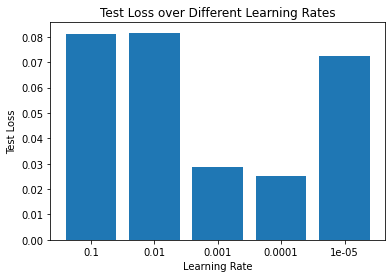

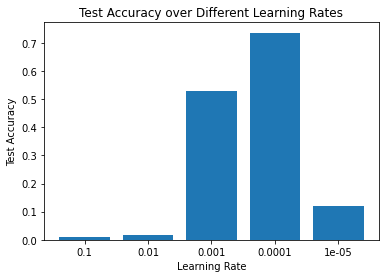

In [73]:
# PLOT LR ACCS AND LOSSES

lrs_list = [str(x) for x in lrs_list]
plt.bar(lrs_list, lr_losses)
plt.xlabel("Learning Rate")
plt.ylabel("Test Loss")
plt.title("Test Loss over Different Learning Rates")

plt.show()

plt.bar(lrs_list, lr_accs)
plt.xlabel("Learning Rate")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy over Different Learning Rates")

plt.show()

## Test Different Number of Epochs

Training and testing model with:	learning_rate=0.001	num_epochs=2	batch_size=64...


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [04:04<00:00, 122.38s/it]


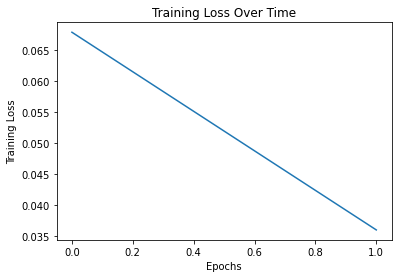

Testing...


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:36<00:00,  1.31it/s]


Average test loss: 0.04
Average test accuracy: 0.3398

Training and testing model with:	learning_rate=0.001	num_epochs=4	batch_size=64...


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [08:08<00:00, 122.04s/it]


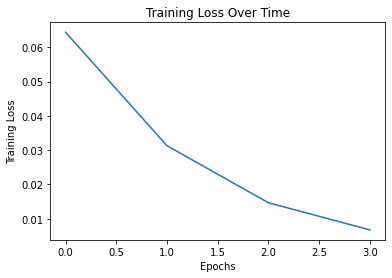

Testing...


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:36<00:00,  1.31it/s]


Average test loss: 0.0231
Average test accuracy: 0.6008

Training and testing model with:	learning_rate=0.001	num_epochs=8	batch_size=64...


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [16:13<00:00, 121.75s/it]


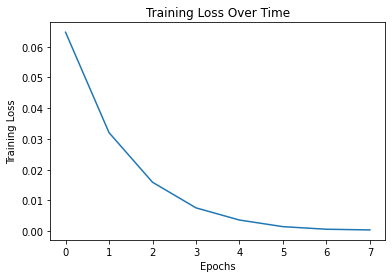

Testing...


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:36<00:00,  1.30it/s]


Average test loss: 0.0156
Average test accuracy: 0.7431

Training and testing model with:	learning_rate=0.001	num_epochs=16	batch_size=64...


100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [32:41<00:00, 122.62s/it]


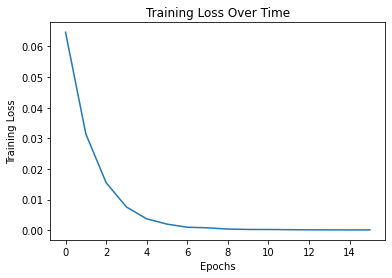

Testing...


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:38<00:00,  1.28it/s]


Average test loss: 0.0124
Average test accuracy: 0.797



In [45]:
# Test different number of epochs
num_epochs_list = [2, 4, 8, 16]
e_losses = []
e_accs = []

for ne in num_epochs_list:
    l, a = train_and_test(num_epochs=ne)
    e_losses.append(l)
    e_accs.append(a)

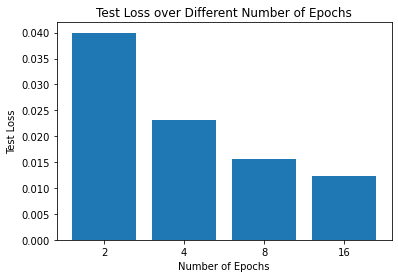

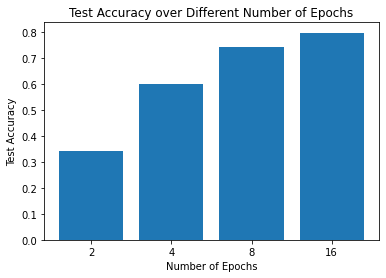

In [75]:
# PLOT NE ACCS AND LOSSES

num_epochs_list = [str(x) for x in num_epochs_list]
plt.bar(num_epochs_list, e_losses)
plt.xlabel("Number of Epochs")
plt.ylabel("Test Loss")
plt.title("Test Loss over Different Number of Epochs")

plt.show()

plt.bar(num_epochs_list, e_accs)
plt.xlabel("Number of Epochs")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy over Different Number of Epochs")

plt.show()

## Test Different Batch Sizes

Training and testing model with:	learning_rate=0.001	num_epochs=5	batch_size=16...


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [10:19<00:00, 123.82s/it]


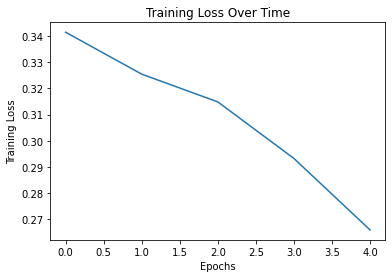

Testing...


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [01:35<00:00,  5.28it/s]


Average test loss: 0.2698
Average test accuracy: 0.063

Training and testing model with:	learning_rate=0.001	num_epochs=5	batch_size=32...


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [10:27<00:00, 125.41s/it]


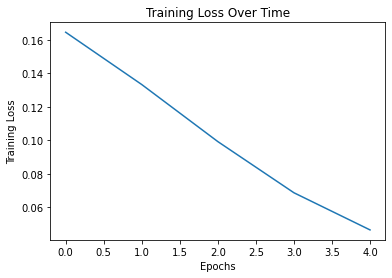

Testing...


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [01:38<00:00,  2.56it/s]


Average test loss: 0.0705
Average test accuracy: 0.4119

Training and testing model with:	learning_rate=0.001	num_epochs=5	batch_size=64...


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [10:06<00:00, 121.38s/it]


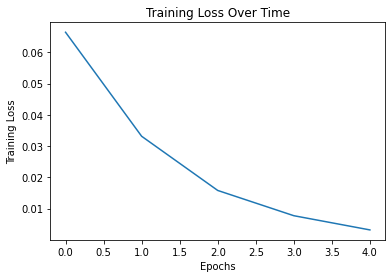

Testing...


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:35<00:00,  1.31it/s]


Average test loss: 0.0206
Average test accuracy: 0.6436

Training and testing model with:	learning_rate=0.001	num_epochs=5	batch_size=128...


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [10:35<00:00, 127.09s/it]


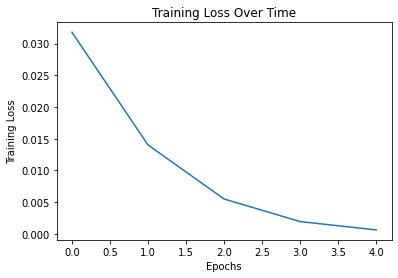

Testing...


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:37<00:00,  1.55s/it]


Average test loss: 0.0077
Average test accuracy: 0.7315



In [47]:
# Test different batch sizes
batch_size_list = [16, 32, 64, 128]
bs_losses = []
bs_accs = []

for b_size in batch_size_list:
    l, a = train_and_test(batch_size=b_size)
    bs_losses.append(l)
    bs_accs.append(a)

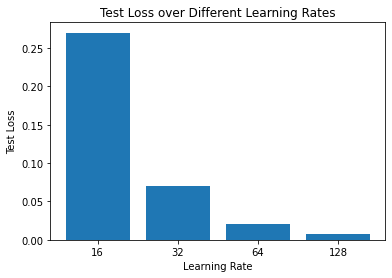

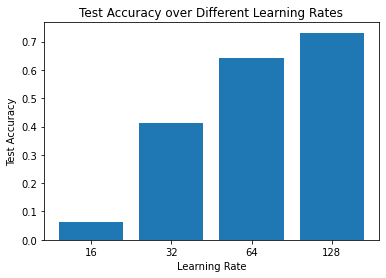

In [76]:
# PLOT BS ACCS AND LOSSES

batch_size_list = [str(x) for x in batch_size_list]
plt.bar(batch_size_list, bs_losses)
plt.xlabel("Learning Rate")
plt.ylabel("Test Loss")
plt.title("Test Loss over Different Learning Rates")

plt.show()

plt.bar(batch_size_list, bs_accs)
plt.xlabel("Learning Rate")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy over Different Learning Rates")

plt.show()


## Write-up:
Provide an explanation for the following items:
* Which part of this lab did you find most difficult?
* What insight did you gain from analyzing the confusion matrix?
* What insight did you gain from your explorations?
* What improvements would you recommend for this lab?

<span style="color:red;">As seen above, best test accuracy achieved: 0.8036</span>

<span style="color:red;">Nothing was too difficult, just waiting for things to train was tough. Also, I didn't have many bugs, but those cuda bugs can be hard to debug sometimes.</span>

<span style="color:red;">None really... I was hoping it would look cooler than it does. Mine is really just a white diagonal line, which I guess is what is desired. It looks like my network does pretty well.</span>

<span style="color:red;">For my explorations, I explored how different learning rates, different batch sizes, and training for a different number of epochs effect model performance on the test set. As we can see in the plots above, the learning rate achieved good performance at 0.001 but the best performance at 0.0001. Anything bigger, or smaller, than those values performed worse. Model performance increased steadily as the batch size increased. Similarly, model performance improved as the number of training epochs increased.</span>

<span style="color:red;">I'm not sure. Maybe have less options to choose from for the explorations. But it was a pretty chill time. Honestly, it might be better to have students make their own network instead of using resnet, since having to create the whole network yourself is a learning experience. Maybe you could have them use the MNIST dataset instead of cars since that one is easier.</span>